./outputs/Cell_101_Test_14


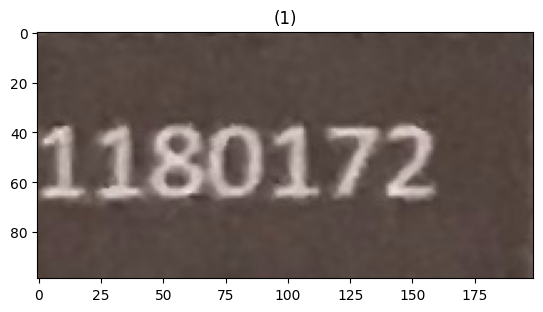

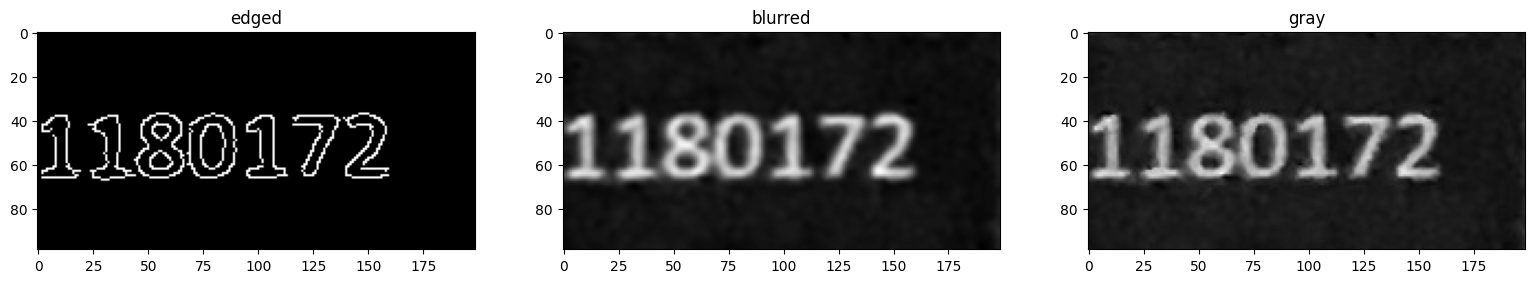

[(2, 38, 18, 29), (2, 47, 7, 18), (23, 38, 22, 30), (44, 37, 23, 30), (68, 37, 23, 30), (74, 42, 12, 21), (95, 38, 19, 29), (116, 38, 22, 28), (139, 37, 21, 30)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


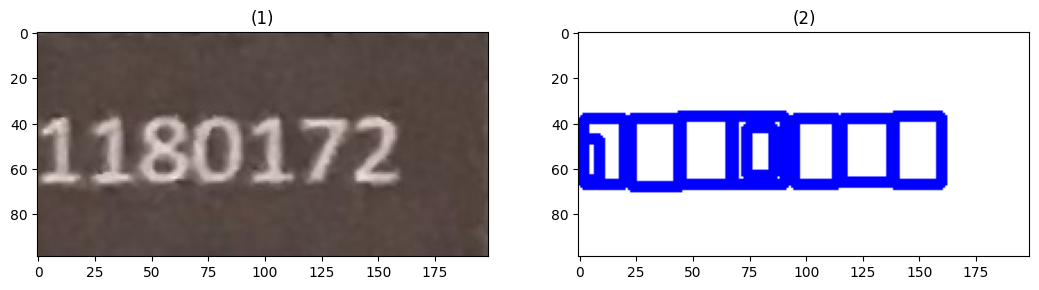

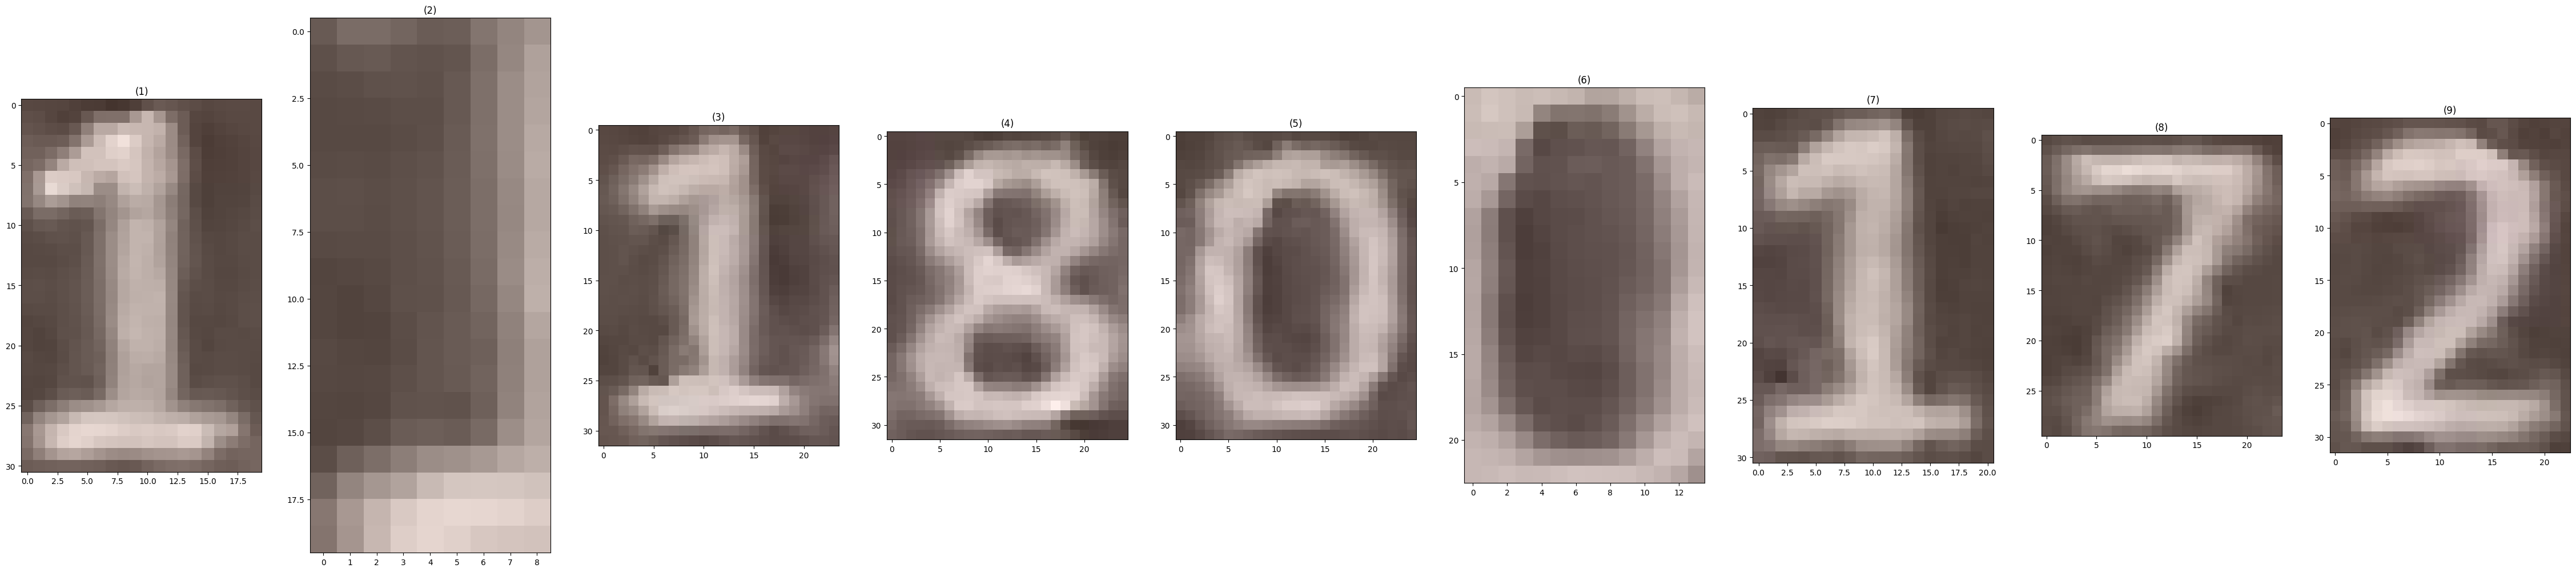

In [45]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from commonfunctions import show_images 
import numpy as np
import os
import scipy.ndimage
from skimage.feature import hog
from skimage import data, color, exposure
from sklearn.model_selection import  train_test_split
from sklearn.neighbors import KNeighborsClassifier
import joblib
import cv2
import imageio.v2 as imageio

path = './outputs/'

def preparePath(imageName):
    path = './outputs/'+imageName
    if not os.path.isdir(f'./outputs/{imageName}'):
        os.makedirs(f'./outputs/{imageName}')
    print(path)
    return path

# def show_images(images, titles=None):
#     n_ims = len(images)
#     if titles is None:
#         titles = ['(%d)' % i for i in range(1, n_ims + 1)]
#     fig = plt.figure()
#     n = 1
#     for image, title in zip(images, titles):
#         a = fig.add_subplot(1, n_ims, n)
#         if image.ndim == 2:
#             plt.gray()
#         plt.imshow(image)
#         a.set_title(title)
#         n += 1
#     fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
#     plt.show()


def segement(img):
    show_images([img])
    kernel = np.ones((5, 5), np.uint8)
    # opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 50, 200, 255)
    show_images([edged,blurred,gray],["edged","blurred","gray"])
    # opening = cv2.erode(opening, kernel, iterations=1)

    # img = cv2.bitwise_not(img)
    # img = cv2.normalize(opening, None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX)
    # res, img = cv2.threshold(img, 64, 255, cv2.THRESH_BINARY)

    # cv2.floodFill(img, None, (0, 0), 255)
    # show_images([img])
    # show_images([img])
    # contours, hierarchy = cv2.findContours((edged).astype("uint8"),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr))
    white_img_large_contours = np.ones(img.shape)
    dimensions_contours = []
    for contour in contours:
        # print(contour)
        (x, y, w, h) = cv2.boundingRect(contour)
        if(w*h > 50):
            dimensions_contours.append((x, y, w, h))
            cv2.rectangle(white_img_large_contours,
                         (x, y), (x+w, y+h), (0, 0, 255), 3)

    print(dimensions_contours)
    show_images([img, white_img_large_contours])
    return dimensions_contours, img

imageName = "Cell_101_Test_14"
img = cv2.imread("../../Training/Dataset/ids/Cell_101_Test_14.jpg")
outputPath = preparePath(imageName)
segmented_dimensions, filtered_img = segement(255*img)

cropped_digits = []
i = 0
for dimension in segmented_dimensions:
    (x, y, w, h) = dimension
    cropped_digits.append(filtered_img[y-1:y+h+1, x-1:x+w+1])
    cv2.imwrite(outputPath+'/'+str(i)+".jpg", filtered_img[y-1:y+h+1, x-1:x+w+1])
    i += 1
show_images(cropped_digits)
# res = segment('./input/c.jpg')
# printChars(res, 6)


9


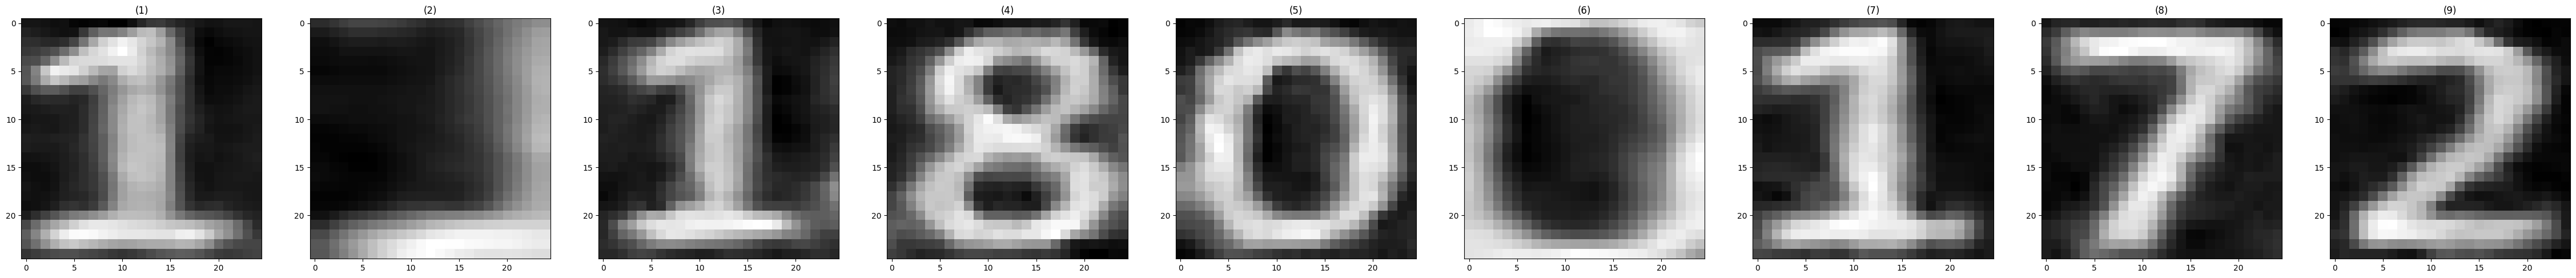

111500172


In [46]:
knn = joblib.load('./models/knn_model.pkl')

# extract the features from the image to predict
def feature_extraction(image):
    return hog(image, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys')


def predict(df):
    predict = knn.predict(df.reshape(1,-1))[0]
    predict_proba = knn.predict_proba(df.reshape(1,-1))
    return predict, predict_proba[0][predict]
digits = []

# load your image from file

testing_directory = './outputs/Cell_101_Test_14/'
print(len(os.listdir(testing_directory)))
for filename in os.listdir(testing_directory):
    image = cv2.imread(testing_directory + filename, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (25, 25))
    digits.append(image)


# image = cv2.imread('../../Training/Dataset/digits/5/Cell_14_Test_4.jpg' , cv2.IMREAD_GRAYSCALE)
# image = cv2.resize(image, (25, 25))
# extract featuress
show_images(digits)
hogs = list(map(lambda x: feature_extraction(x), digits))
# apply k-NN model created in previous
predictions = list(map(lambda x: predict(x), hogs))

predictedNumber = ""
# print(predictions)
for number, accuracy in predictions:
    # print(number)
    predictedNumber += str(number)

print(predictedNumber)